In [4]:
import torch
from torch.autograd import Variable
from jointangleenergy import JointAngleEnergy 
#import a pointnet somewhere as PointNet

In [21]:
sampler = JointAngleEnergy('saved/EBGAN/best.pth')

In [35]:
samples = sampler.generate_samples(10)
print(samples)

[[ 1.17217734e-01  4.05775219e-01  6.99375153e-01  5.57370603e-01
  -7.41050160e-03  1.22319825e-01  4.93859231e-01  2.35075220e-01
  -9.65070650e-02  5.05146027e-01  6.92283034e-01  6.63371921e-01
  -2.23953515e-01  7.36941636e-01  6.92845047e-01  7.22581387e-01
   6.01268671e-02 -4.25363809e-01  5.73860347e-01  3.33021194e-01]
 [ 1.43462434e-01  6.90441549e-01  5.31590521e-01  5.76857209e-01
  -7.96298590e-03  5.45748532e-01  1.99482992e-01  2.14737847e-01
  -1.62149221e-01  3.62572908e-01  4.64317314e-02  1.35199159e-01
  -1.20936282e-01  4.14337665e-01  9.71565396e-02  2.74194002e-01
   1.86952025e-01 -4.48685259e-01  5.35278082e-01  3.35957497e-01]
 [ 1.09182723e-01  6.43800735e-01  7.16292918e-01  6.82400048e-01
  -2.35992507e-03  2.73661405e-01  3.63300025e-01  1.65378049e-01
  -1.16756685e-01  3.99471730e-01  4.34685737e-01  4.19175595e-01
  -1.35631010e-01  7.19474673e-01  5.34893036e-01  5.91993034e-01
   2.46649273e-02 -3.76600832e-01  5.35269499e-01  3.26526105e-01]
 [ 1.54

[0.39925736]


<IPython.core.display.Javascript object>


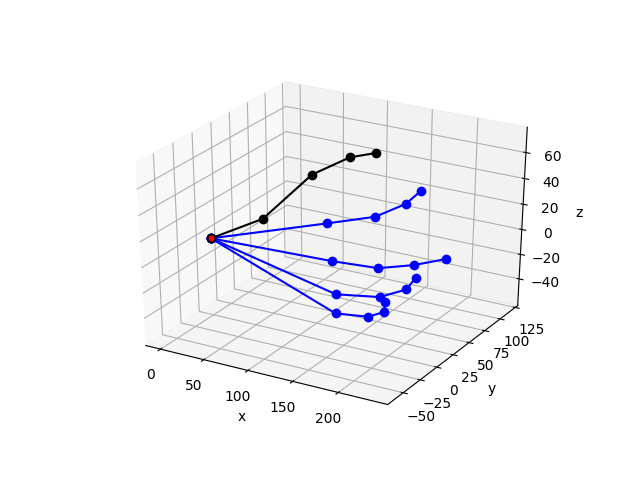

In [46]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import utils.hand as hand


sample = torch.FloatTensor(samples[0].reshape(1, -1))
sampler.discriminator.eval()
print(sampler.get_joint_angle_energy(sample))

#
# Make hand and update DOFs
#
start = np.array([[0., 0., 0.]]).T  
quat = np.array([0., 0., 0., 1.])

h = hand.makeHumanHand(start, quat)
h.updateDofs(sample.data.numpy().reshape(-1)) # don't forget to do this 
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T


#############
# PLOT HAND #
#############

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
# ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()

In [47]:
# generate random hand pose that looks like shit
# perturb perturb perturb

In [126]:
N_ITERS = 1000
SIGMA = 0.2
SAMPLES_PER_IT = 50
ALPHA = 0.01
N_THETAS = 10

In [128]:
from scipy.linalg import norm
sampler.discriminator.eval()
thetas = []
for i in range(N_THETAS):
    theta = np.random.randn(1, 20)
    for t in range(N_ITERS):
        epsilons = np.random.randn(SAMPLES_PER_IT, 20)
        perturbations = theta + epsilons*SIGMA
        energies = sampler.get_joint_angle_energy(torch.from_numpy(perturbations))
        weighted_epsilons = np.einsum('i, ij -> ij', energies, epsilons)
        theta_update = ALPHA/(SAMPLES_PER_IT*SIGMA)*weighted_epsilons.sum(axis=0)
        theta -= theta_update
        #print(norm(theta_update))
    thetas.append(theta)
    #print(sampler.get_joint_angle_energy(torch.from_numpy(theta)))

In [130]:
print(thetas[0])

[[ 0.33244208  0.05818309  1.21344488  0.6515434   0.01763143  0.14994093
   1.25793673  0.70923056 -0.33407313  0.10936415  1.00654947  0.70554548
  -0.46424321  0.46320511  0.83525354  0.93479216 -0.00801752 -0.7205892
   0.90733776  0.49373472]]


In [131]:
print(thetas[1])

[[ 0.27497479  0.85823546  0.64853559  0.45283947 -0.00387798  0.6290001
   0.27775394  0.11708983 -0.30121292  0.66918548  0.28855238  0.39455118
  -0.40020112  0.76898944  0.10305981  0.23762479  0.45641395 -0.84155849
   1.00594386  0.58506741]]


In [118]:
(torch.ones(3) * torch.ones(3, 5)).size()

RuntimeError: The size of tensor a (3) must match the size of tensor b (5) at non-singleton dimension 1

In [ ]:
torch.einsum('')

<IPython.core.display.Javascript object>


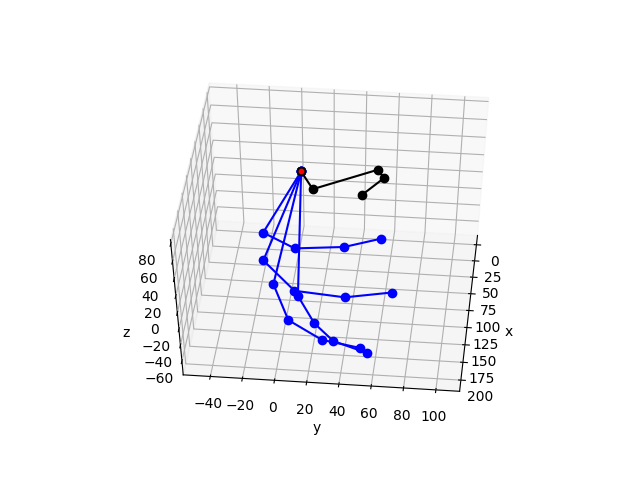

In [124]:
#
# Make hand and update DOFs
#
start = np.array([[0., 0., 0.]]).T  
quat = np.array([0., 0., 0., 1.])

h = hand.makeHumanHand(start, quat)
h.updateDofs(theta.reshape(-1)) # don't forget to do this 
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T


#############
# PLOT HAND #
#############

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
# ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()

In [120]:
print(theta)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]
